## Simulation system

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Početni parametri

In [36]:
# Simulation parameters
num_points = 3 * 30 * 24 * 60  # 3 months of data, assuming 30 days per month
anomaly_chance = np.random.uniform(0.00005, 0.00012)  # [0.005-0.012]% chance of an anomaly
times = pd.date_range(start="2024-04-20", periods=num_points, freq='T')

# Anomaly counter
anomalies = 0

### Generiranje podataka

In [45]:
# Initialize sensors
accelerometer = np.zeros((num_points, 3))
gyroscope = np.zeros((num_points, 3))
magnetometer = np.zeros((num_points, 3))
temperature = np.full(num_points, 37)
pressure = np.full(num_points, 100)
light = np.full(num_points, 100)
behavior = np.full(num_points, "resting")

# Define behavior probabilities and transitions
curr_behavior = "resting"
behavior_duration = 0
time_since_last_change = 0

for i in range(1, num_points):
    current_minute = i % 1440  # Current minute in the day

    # Reset sleep time at the start of each day
    if current_minute == 0:
        sleep_start_time = np.random.randint(18 * 60, 24 * 60)  # Sleep can start between 6pm and 12am
        sleep_duration = np.random.randint(3 * 60, 4 * 60 + 1)  # Sleep duration between 3 and 4 hours in minutes

    # Check if it's time to sleep
    if sleep_start_time <= current_minute < sleep_start_time + sleep_duration:
        curr_behavior = "sleeping"
    else:
        if behavior_duration <= 0:
            change_probability = 0.05 + 0.001 * time_since_last_change
            if np.random.random() < change_probability:
                possible_behaviors = ["running", "walking", "resting"]
                if curr_behavior in possible_behaviors:
                    possible_behaviors.remove(curr_behavior)  # Remove current behavior from the list if it exists
                curr_behavior = np.random.choice(possible_behaviors)
                min_behavior_duration = {"running": 10, "walking": 20, "resting": 30}[curr_behavior]
                behavior_duration = np.random.randint(min_behavior_duration, min_behavior_duration + 20)
                time_since_last_change = 0
        else:
            behavior_duration -= 1
            time_since_last_change += 1


    # Sensor data generation based on behavior
    if curr_behavior == "running":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(5, 2, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(300, 50, 3)
        behavior[i] = "running"
    elif curr_behavior == "walking":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(1, 0.5, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(100, 20, 3)
        behavior[i] = "walking"
    elif curr_behavior == "resting":
        accelerometer[i] = accelerometer[i-1] + np.random.normal(0, 0.1, 3)
        gyroscope[i] = gyroscope[i-1] + np.random.normal(0, 5, 3)
        behavior[i] = "resting"
    elif curr_behavior == "sleeping":
        accelerometer[i] = np.random.normal(0, 0.05, 3)
        gyroscope[i] = np.random.normal(0, 1, 3)
        behavior[i] = "sleeping"


### Anomalije

In [19]:
# Introducing anomalies with variable lengths

for _ in range(int(num_points * anomaly_chance)):
    start = np.random.randint(0, num_points)
    duration = np.random.randint(30, int(1.5 * 24 * 60))  # From 30 minutes to 1.5 days (in minutes)
    end = min(start + duration, num_points)

    # Randomly choose which sensors will have anomalies
    sensors = ['accelerometer', 'gyroscope', 'magnetometer', 'temperature', 'pressure', 'light']
    num_sensors_affected = np.random.choice([1, 2], p=[0.8, 0.2])  # 80% chance for 1 sensor, 20% for 2 sensors
    affected_sensors = np.random.choice(sensors, size=num_sensors_affected, replace=False)

    if 'accelerometer' in affected_sensors:
        accelerometer[start:end] += np.random.normal(2, 1, (end - start, 3))
    if 'gyroscope' in affected_sensors:
        gyroscope[start:end] += np.random.normal(300, 50, (end - start, 3))
    if 'magnetometer' in affected_sensors:
        magnetometer[start:end] += np.random.normal(100, 20, (end - start, 3))
    if 'temperature' in affected_sensors:
        temperature[start:end] += np.random.normal(10, 2, end - start)
    if 'pressure' in affected_sensors:
        pressure[start:end] += np.random.normal(15, 5, end - start)
    if 'light' in affected_sensors:
        light[start:end] = 0

    print("Hours of anomaly: ", (duration)/24)
    anomalies += 1

Hours of anomaly:  31.458333333333332


UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('int32') with casting rule 'same_kind'

### Izrada DataFrame-a

In [46]:
# Print the number of anomalies
print(f"Number of anomalies: {anomalies}")

# Create DataFrame
df = pd.DataFrame({
    'Accelerometer_X': accelerometer[:, 0],
    'Accelerometer_Y': accelerometer[:, 1],
    'Accelerometer_Z': accelerometer[:, 2],
    'Gyroscope_X': gyroscope[:, 0],
    'Gyroscope_Y': gyroscope[:, 1],
    'Gyroscope_Z': gyroscope[:, 2],
    'Magnetometer_X': magnetometer[:, 0],
    'Magnetometer_Y': magnetometer[:, 1],
    'Magnetometer_Z': magnetometer[:, 2],
    'Temperature': temperature,
    'Pressure': pressure,
    'Light': light,
    'Time': times,
    'Behavior': behavior
}, index=times)

Number of anomalies: 0


### Prikazivanje podataka

       Accelerometer_X  Accelerometer_Y  Accelerometer_Z    Gyroscope_X  \
count    129600.000000    129600.000000    129600.000000  129600.000000   
mean        937.853107       936.027718       936.355597   63853.904861   
min          -1.210383        -1.351325        -1.894128     -71.683562   
25%         305.671423       307.040337       308.784032   21194.919375   
50%         889.455984       886.543932       890.236037   61104.155250   
75%        1503.317245      1490.280691      1497.157906  102038.663511   
max        2982.201514      3092.852971      3135.620039  204362.140927   
std         703.976437       705.282306       703.838031   47569.379148   

         Gyroscope_Y    Gyroscope_Z  Magnetometer_X  Magnetometer_Y  \
count  129600.000000  129600.000000        129600.0        129600.0   
mean    63780.504850   63828.889767             0.0             0.0   
min       -51.246049     -62.993495             0.0             0.0   
25%     21331.398127   21383.376297     

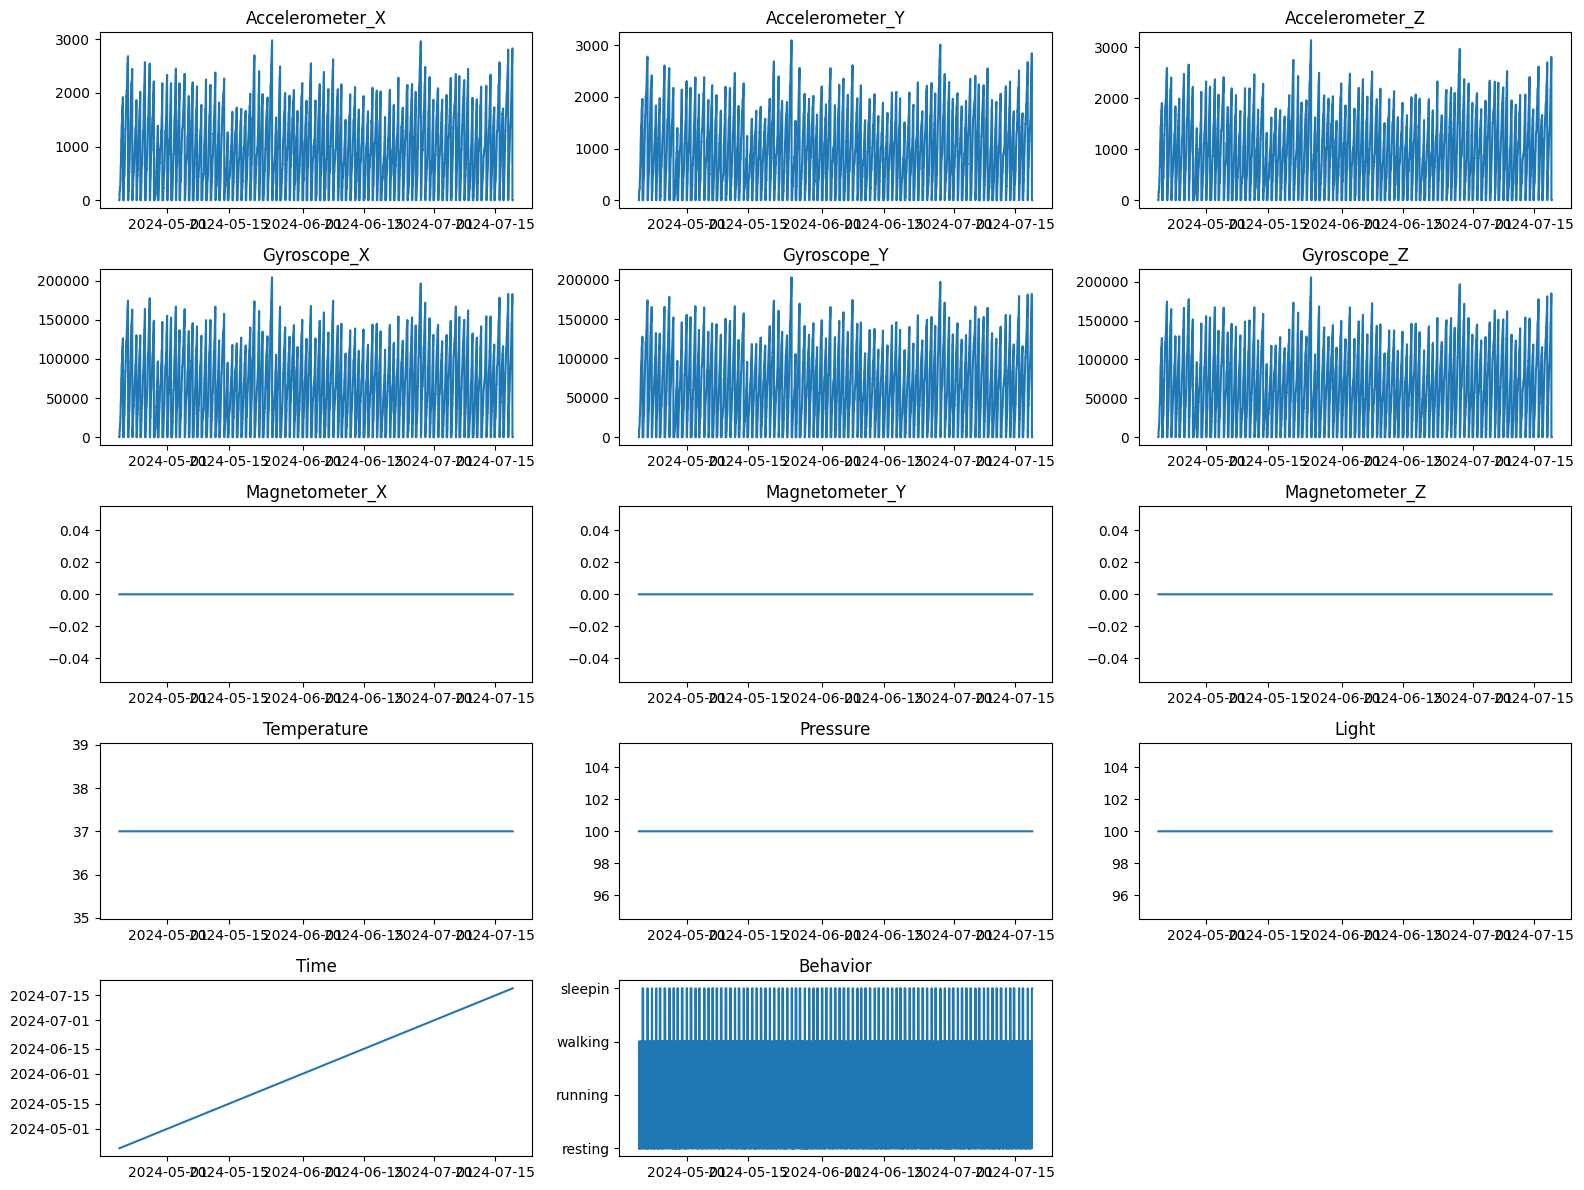

In [47]:
# Displaying statistical summary of the data
print(df.describe())

# Displaying the data
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns):
    plt.subplot(5, 3, i + 1)
    plt.plot(df.index, df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

### Spremanje podataka u CSV datoteku

In [48]:
# Sava data to CSV file
df.to_csv('sensor_data.csv')